# PCR flanks

## 1. Imports, constants and parameters

In [1]:
from collections import Counter
import gzip

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import regex
import seaborn as sns

In [2]:
input_path = '../../../projects/ONT/data/pcr2persons/fastq/'
output_path = '../../../projects/ONT/data/pcr2persons/output/'

# label = '_00_05'
# fastq_paths = [f'{input_path}AQD087_pass_fae3d762_8343086c_{i}.fastq.gz' for i in range(6)]

label = '_00_67'
fastq_paths = [f'{input_path}AQD087_pass_fae3d762_8343086c_{i}.fastq.gz' for i in range(68)]

In [3]:
prefix = 'AGAAAGAAATGGTCTGTGATCCCCC'
suffix = 'CATTCCCGGCTACAAGGACCCTTCG'
motif = 'CAG'
tolerance = '{s<=5}'

In [4]:
comps = {
    'A': 'T',
    'C': 'G',
    'G': 'C',
    'T': 'A'
}

## 2. Classes and functions

In [5]:
def rev_comp(seq, comps):
    return ''.join(comps.get(n, n) for n in reversed(seq))

In [6]:
def modes(s, num_of_modes=20):
    return s.value_counts().nlargest(num_of_modes)

In [7]:
def transform_insert(insert):
    if not insert:
        return ''

    if insert.startswith('AGC'):
        insert = 'c' + insert
    elif insert.startswith('GCA'):
        insert = 'ca' + insert

    if insert.endswith('GCA'):
        insert = insert + 'g'
    elif insert.endswith('AGC'):
        insert = insert + 'ag'

    # insert = insert.replace('CAG', '-->')

    return insert

In [8]:
def gap_count(insert):
    return len(insert.replace('CAG', ''))

In [9]:
class Read:
    def __init__(
        self,
        id,
        seq,
        opt,
        qual
    ):
        self.id = id
        seq = seq.upper()
        self.seq = {
            'fwd': seq,
            'rev': rev_comp(seq, comps)
        }
        self.opt = opt
        self.qual = {
            'fwd': qual,
            'rev': ''.join(reversed(qual))
        }
        self.read_length = len(seq)

    def rows(self):
        ress = []
        for direction in self.seq:
            res = {
                'id': self.id,
                'direction': direction,
                'seq': self.seq[direction],
                'opt': self.opt,
                'qual': self.qual[direction],
                'read_length': self.read_length
            }

            ress.append(pd.Series(res))

        return ress

In [10]:
def read_fastq(fastq_path):
    reads = []
    with gzip.open(fastq_path, 'rt') as f:
        for i, line in enumerate(f):
            line = line.strip()
            if i%4 == 0:
                if line.startswith('@'):
                    id = line
                else:
                    print('Error')
                    raise
            elif i%4 == 1:
                seq = line
            elif i%4 == 2:
                if line.startswith('+'):
                    opt = line
                else:
                    print('Error')
                    raise
            elif i%4 == 3:
                qual = line
                reads.append(Read(id, seq, opt, qual))
    return reads

## 3. Load the data

In [11]:
reads = []

for fastq_path in fastq_paths:
    reads.extend(read_fastq(fastq_path))

df = pd.DataFrame([row for r in reads for row in r.rows()])
print(len(reads), df.shape)
df.head(3)

203641 (407282, 6)


,id,direction,seq,opt,qual,read_length
0,@8b642f7f-33ad-40c1-bd3b-423605bad973 runid=83...,fwd,GGTACTGTGTAACCTACTCGTTCAGTAGGGTCTTACTCAGAGACGA...,+,"&&&'''())(*)..2455.**)&&&&&(*,..22'(()++)0+,'&...",722
1,@8b642f7f-33ad-40c1-bd3b-423605bad973 runid=83...,rev,TGACGTATTGCTGTTCGCCGTCGTTCTGTCGTGCCGCTGCCTGGGC...,+,"&*002-,,-556CCE>>>)))(*-%%(%&'1***'))(*/028,./...",722
2,@0b5f39ab-94b3-43d0-958b-1961a0b71584 runid=83...,fwd,GTAGCCTGCTGGAACCGTTGGCGTCTTGTTCGGAGGACGAGGTCAA...,+,##$$$#%%&(%&&'%$##$%%&&'%%&%)*(*88A;63228:;9)(...,740


In [12]:
def props(row):
    length = row['read_length']
    counter = Counter(row['seq'])
    contents = {c: counter[c]/length for c in counter}

    if contents.keys() - comps.keys():
        print(contents.keys() - comps.keys())

    if comps.keys() - contents.keys():
        print(comps.keys() - contents.keys())
    
    prefix_s = f'({prefix})' + tolerance
    prefixes = regex.findall(prefix_s, row['seq'])

    suffix_s = f'({suffix})' + tolerance
    suffixes = regex.findall(suffix_s, row['seq'])

    motifs = regex.findall(motif, row['seq'])

    motif_ins = []
    ins = ''
    ins_ext = ''
    ins_ext_len = 0
    ins_ext_gap_count = 0
    ins_len = 0
    start = None
    end = None
    if len(prefixes) == 1 and len(suffixes) == 1:
        start_tmp = row['seq'].index(prefixes[0]) + len(prefixes[0])
        end_tmp = row['seq'].index(suffixes[0])
        if end_tmp > start_tmp:
            start, end = start_tmp, end_tmp
            ins = row['seq'][start:end]
            motif_ins = regex.findall(motif, ins)
            ins_len = end - start
            ins_ext = transform_insert(ins)
            ins_ext_len = len(ins_ext)
            ins_ext_gap_count = gap_count(ins_ext)

    return pd.Series({
        'a': contents.get('A', 0),
        'c': contents.get('C', 0),
        'g': contents.get('G', 0),
        't': contents.get('T', 0),
        'prefixes': len(prefixes),
        'suffixes': len(suffixes),
        'motifs': len(motifs),
        'motif_ins': len(motif_ins),
        'ins': ins,
        'ins_ext': ins_ext,
        'ins_ext_len': ins_ext_len,
        'ins_ext_gap_count': ins_ext_gap_count,
        'ins_len': ins_len,
        'start': start,
        'end': end
    })

In [13]:
df = pd.concat([df, df.apply(props, axis=1)], axis=1)

In [14]:
df['gc'] = df['g'] + df['c']
df['cag'] = df['c'] + df['a'] + df['g']

## 4. Overview

407282
read_length
724    3918
725    3824
723    3758
722    3728
726    3726
Name: count, dtype: int64


<Axes: xlabel='read_length', ylabel='Count'>

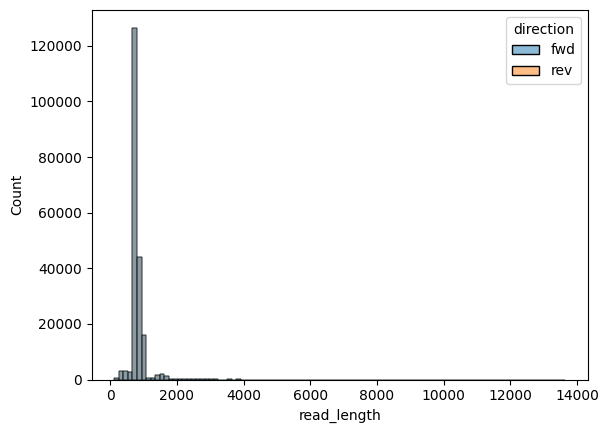

In [15]:
print(len(df))
print(modes(df['read_length'], 5))
# df['read_length'].hist(bins=100)
sns.histplot(df, x='read_length', bins=100, hue='direction')

gc
0.666667    2636
0.666667    1266
0.652174     872
0.655172     802
0.653846     716
Name: count, dtype: int64


<Axes: xlabel='gc', ylabel='Count'>

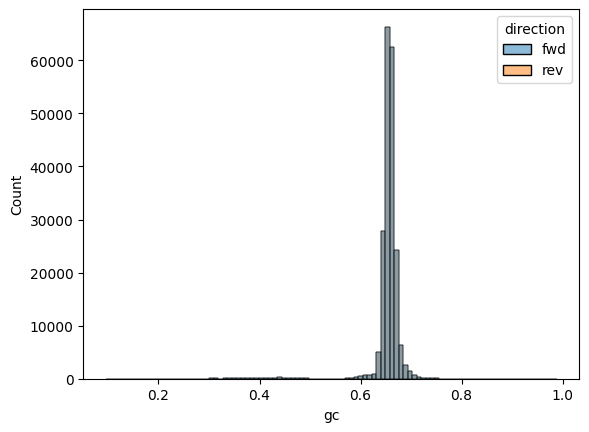

In [16]:
print(modes(df['gc'], 5))
sns.histplot(df, x='gc', bins=100, hue='direction')

cag
0.800000    874
0.875000    801
0.857143    666
0.789474    466
0.866667    432
Name: count, dtype: int64


<Axes: xlabel='cag', ylabel='Count'>

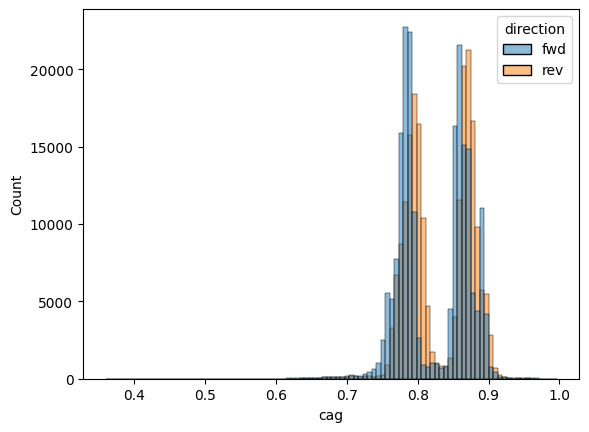

In [17]:
print(modes(df['cag'], 5))
sns.histplot(df, x='cag', bins=100, hue='direction')

prefixes
0    265896
1    139621
2      1697
3        57
4        11
Name: count, dtype: int64


<Axes: xlabel='prefixes', ylabel='Count'>

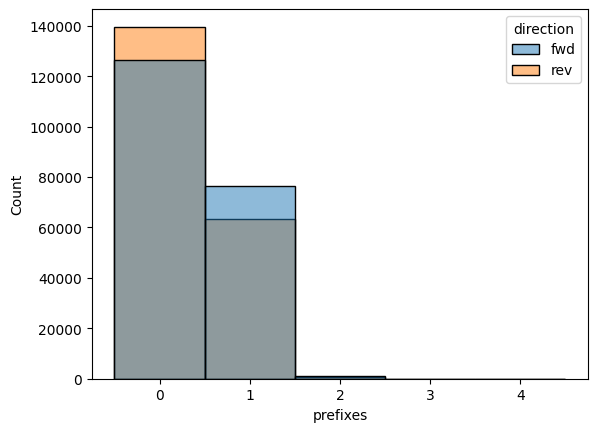

In [18]:
print(modes(df['prefixes'], 5))
sns.histplot(df, x='prefixes', discrete=True, hue='direction')

suffixes
0    311865
1     94419
2       973
3        24
4         1
Name: count, dtype: int64


<Axes: xlabel='suffixes', ylabel='Count'>

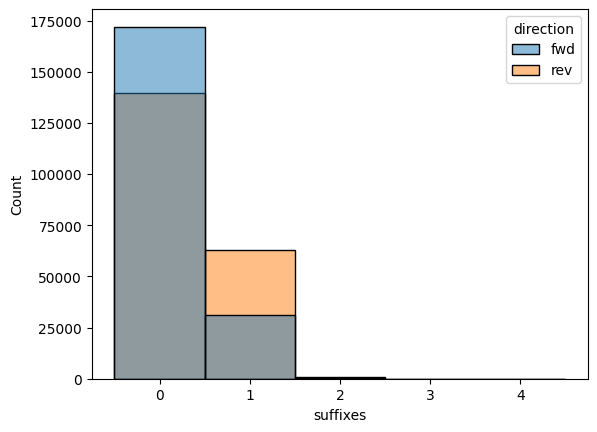

In [19]:
print(modes(df['suffixes'], 5))
sns.histplot(df, x='suffixes', discrete=True, hue='direction')

In [20]:
# sns.stripplot(data=df, x="prefixes", y="suffixes", s=20, marker="D", linewidth=1, alpha=.1, hue='direction')

start
348.0    3084
349.0    2997
347.0    2972
346.0    2901
350.0    2837
Name: count, dtype: int64


<Axes: xlabel='start', ylabel='Count'>

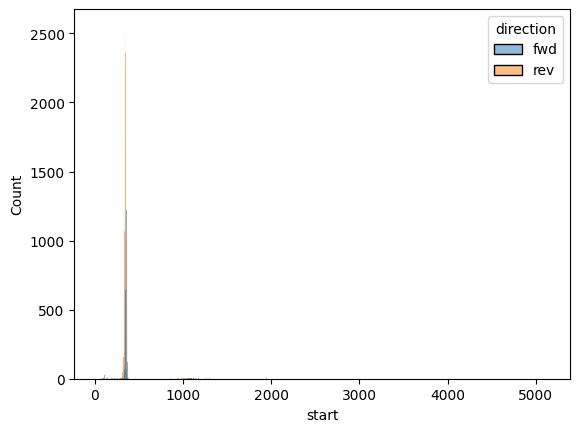

In [21]:
print(modes(df['start'], 5))
sns.histplot(df, x='start', discrete=True, hue='direction')

end
364.0    1176
361.0    1124
362.0    1121
363.0    1116
365.0    1097
Name: count, dtype: int64


<Axes: xlabel='end', ylabel='Count'>

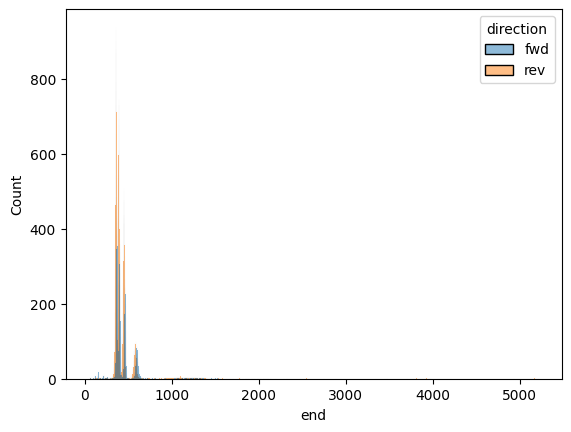

In [22]:
print(modes(df['end'], 5))
sns.histplot(df, x='end', discrete=True, hue='direction')

ins_len
15    11328
48     6153
14     4886
45     3223
47     2931
Name: count, dtype: int64


<Axes: xlabel='ins_len', ylabel='Count'>

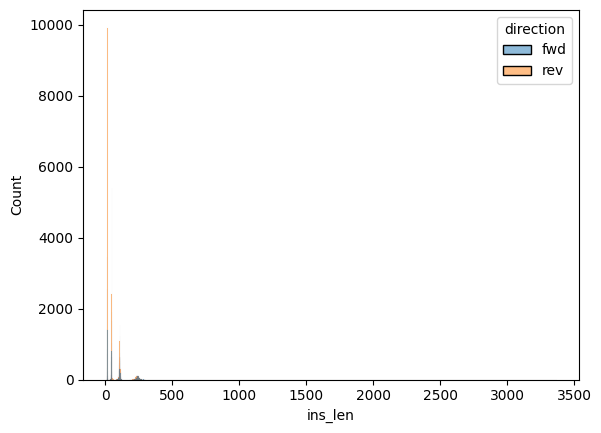

In [23]:
cond = df['ins_len'] > 0
print(modes(df[cond]['ins_len'], 5))
sns.histplot(df[cond], x='ins_len', discrete=True, hue='direction')

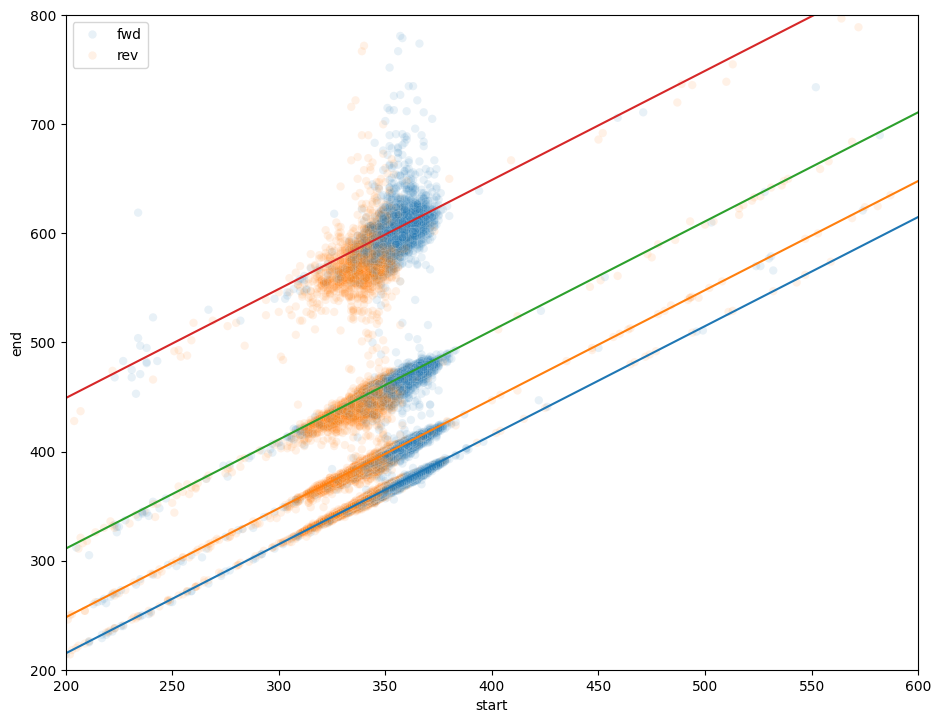

In [24]:
fig, ax = plt.subplots(figsize=(11, 8.5))
gfg = sns.scatterplot(data=df, x="start", y="end", ax=ax, alpha=0.1, hue='direction')
x_pred = np.linspace(0, 1500, 50)
y_pred = x_pred + 15
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 48
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 111
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 249
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
gfg.set_xlim(200, 600)
gfg.set_ylim(200, 800)
fig.savefig(f'{output_path}inserts{label}.png')

## 5. Insert analysis

In [25]:
for direction in ['fwd', 'rev']:
    # cond = (df['prefixes'] == 1) & (df['suffixes'] == 1)
    cond = (df['start'] > 300) & (df['start'] < 400)
    cond &= df['direction'] == direction
    with open(f'{output_path}{direction}_ins_ext{label}.txt', 'wt') as f:
        for ins in list(df[cond].sort_values(['ins_ext_len', 'ins_ext_gap_count', 'ins_ext'])['ins_ext']):
            f.write(ins + '\n')

## 6. Clean up and form consensus sequence

<Axes: >

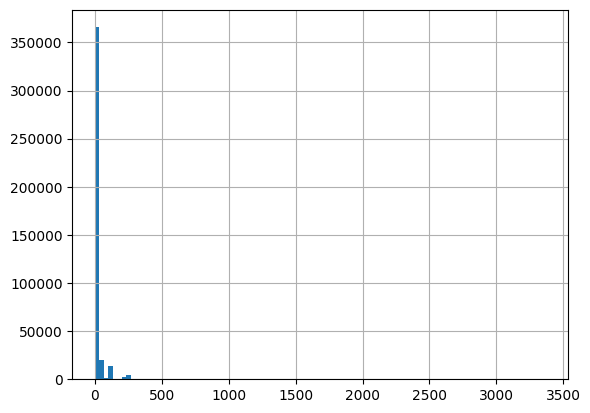

In [26]:
df['ins_ext_len'].hist(bins=100)

In [27]:
cond = (df['start'] > 300) & (df['start'] < 400)
len(df[cond])

62431

(200.0, 800.0)

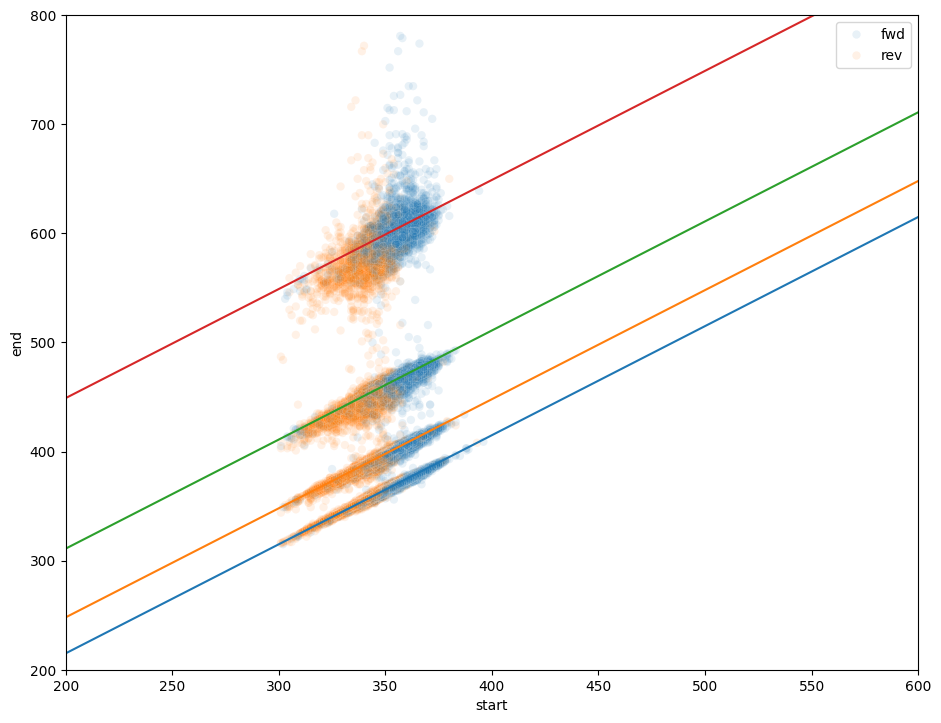

In [28]:
fig, ax = plt.subplots(figsize=(11, 8.5))
gfg = sns.scatterplot(data=df[cond], x="start", y="end", ax=ax, alpha=0.1, hue='direction')
x_pred = np.linspace(0, 1500, 50)
y_pred = x_pred + 15
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 48
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 111
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
y_pred = x_pred + 249
sns.lineplot(x=x_pred, y=y_pred, ax=ax)
gfg.set_xlim(200, 600)
gfg.set_ylim(200, 800)

In [29]:
def consensus_string(strings):
    if not strings or not all(len(strings[0]) == len(s) for s in strings):
        raise ValueError("Input strings must be non-empty and of equal length")

    consensus = ''
    for i in range(len(strings[0])):
        # Create a dictionary to count occurrences of each character at the current position
        char_count = {}
        for s in strings:
            char = s[i]
            char_count[char] = char_count.get(char, 0) + 1

        # Find the most frequent character at the current position
        most_frequent_char = max(char_count, key=char_count.get)

        # Append the most frequent character to the consensus string
        consensus += most_frequent_char

    return consensus

In [30]:
cond = (df['start'] > 300) & (df['start'] < 400)
cond &= df['ins_ext_len'] < 500
ins_ext_lengths = df[cond]['ins_ext_len'].unique()

In [31]:
consensi = []
for ins_ext_length in sorted(ins_ext_lengths):
    cond = df['ins_ext_len'] == ins_ext_length
    cond &= (df['start'] > 300) & (df['start'] < 400)
    inss = list(df[cond]['ins_ext'])
    consensi.append([ins_ext_length, len(inss), consensus_string(inss)])

df_consensus = pd.DataFrame(consensi, columns=['ins_ext_len', 'count', 'seq'])
df_consensus.to_csv(f'{output_path}consensus{label}.tsv', index=False, sep='\t')
df_consensus[0:20]

,ins_ext_len,count,seq
0,2,1,CA
1,3,1,CAG
2,7,1,CAGACAG
3,8,2,CTGAGCAG
4,9,53,CAGCAGCAG
5,10,20,CAGACAGCAG
6,11,49,CAGCAGCGCAG
7,12,1316,CAGCAGCAGCAG
8,13,272,CAGCCAGCAGCAG
9,14,601,CAGCAGAGCAGCAG


<Axes: xlabel='ins_ext_len', ylabel='count'>

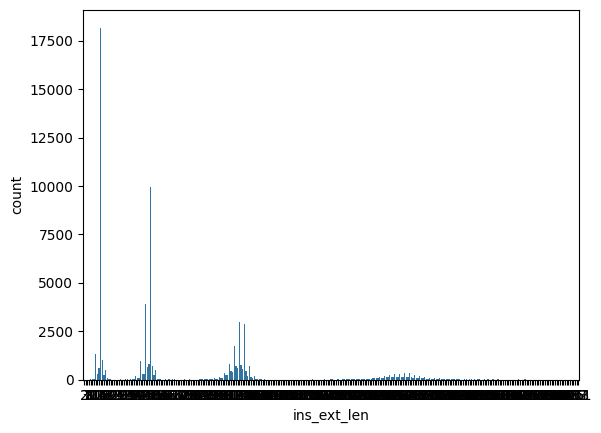

In [33]:
sns.barplot(x='ins_ext_len', y='count', data=df_consensus)
# # plt.xticks(ticks=[15, 48, 111, 249], labels=[15, 48, 111, 249])  # Set the ticks and labels as needed
# plt.xticks(rotation=90)
# plt.show()

In [34]:
def find_local_maxima(nums):
    local_maxima = []

    # Check each element in the list
    for i in range(1, len(nums) - 1):
        if nums[i] > nums[i - 1] and nums[i] > nums[i + 1]:
            local_maxima.append((i, nums[i]))

    # Check the first and last elements
    if len(nums) > 1 and nums[0] > nums[1]:
        local_maxima.insert(0, (0, nums[0]))
    if len(nums) > 1 and nums[-1] > nums[-2]:
        local_maxima.append((len(nums) - 1, nums[-1]))

    return local_maxima

In [35]:
find_local_maxima(list(df_consensus['count']))

[(4, 53),
 (7, 1316),
 (10, 18187),
 (13, 510),
 (22, 7),
 (25, 11),
 (28, 47),
 (31, 179),
 (34, 973),
 (37, 3908),
 (40, 9962),
 (43, 515),
 (46, 22),
 (49, 6),
 (51, 9),
 (53, 6),
 (56, 4),
 (60, 5),
 (63, 11),
 (69, 13),
 (72, 23),
 (75, 36),
 (78, 57),
 (81, 150),
 (84, 333),
 (87, 795),
 (90, 1732),
 (93, 2957),
 (96, 2887),
 (99, 699),
 (102, 204),
 (105, 36),
 (108, 9),
 (111, 2),
 (114, 2),
 (123, 2),
 (128, 3),
 (130, 2),
 (135, 4),
 (137, 5),
 (142, 3),
 (144, 5),
 (152, 7),
 (156, 10),
 (159, 12),
 (162, 20),
 (165, 32),
 (168, 37),
 (171, 52),
 (174, 89),
 (177, 124),
 (180, 161),
 (183, 223),
 (186, 274),
 (189, 299),
 (192, 331),
 (195, 316),
 (198, 240),
 (201, 195),
 (204, 130),
 (207, 94),
 (210, 58),
 (213, 56),
 (216, 34),
 (219, 23),
 (222, 17),
 (225, 17),
 (228, 9),
 (231, 11),
 (234, 7),
 (237, 14),
 (240, 6),
 (242, 7),
 (245, 6),
 (248, 5),
 (257, 3),
 (260, 5),
 (262, 4),
 (264, 5),
 (267, 3),
 (270, 4),
 (283, 2)]